In [ ]:
!pip install tensorflow tensorflow-cpu opencv-python matplotlib

In [1]:
import tensorflow as tf
import os

### 1. Clean Dataset

In [2]:
import cv2
import imghdr

C:\Users\guill\AppData\Local\Temp\ipykernel_19136\4232469594.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [3]:
data_dir = base_dir = r'spinal_canal_stenosis'

In [7]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [8]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

## 2. Load Data

In [4]:
import numpy as np
from matplotlib import pyplot as plt

In [5]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 2753 files belonging to 3 classes.


In [6]:
def count_images(folder_path):
    classes = os.listdir(folder_path)
    for cls in classes:
        print(f"Class {cls}: {len(os.listdir(os.path.join(folder_path, cls)))} images")

count_images(data_dir)

Class Normal_Mild: 2414 images
Class Moderate: 224 images
Class Severe: 115 images


### 2.1 Augment Data

In [37]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Augmentation generator
datagen = ImageDataGenerator(
    # when first worked with rotation, the model gave me a lot of issues, but good accuracy rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [11]:
# Augment images from a folder
def augment_class(folder_path, target_size, save_to_dir):
    # Ensure save_to_dir exists
    os.makedirs(save_to_dir, exist_ok=True)
    
    images = os.listdir(folder_path)
    num_existing = len(images)
    num_to_augment = target_size - num_existing

    if num_to_augment <= 0:
        print(f"No augmentation needed for {folder_path}")
        return

    # Calculate how many augmentations per original image
    augment_per_image = num_to_augment // num_existing
    extra_augments = num_to_augment % num_existing  # For rounding issues

    print(f"Augmenting {folder_path}: Existing={num_existing}, Target={target_size}")

    for idx, img_name in enumerate(images):
        img_path = os.path.join(folder_path, img_name)
        img = tf.keras.preprocessing.image.load_img(img_path)
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = img_array.reshape((1,) + img_array.shape)

        # Generate augmented images
        for i, batch in enumerate(datagen.flow(img_array, batch_size=1, save_to_dir=save_to_dir, save_prefix='aug', save_format='jpeg')):
            if i >= augment_per_image + (1 if idx < extra_augments else 0):
                break  # Stop once desired count for this image is reached

    print(f"Augmentation complete for {folder_path}. Saved to {save_to_dir}.")

In [38]:
def augment_and_transfer(source_folder, target_folder, augmentations=5):

    # Ensure target folder exists
    os.makedirs(target_folder, exist_ok=True)

    # List images in the source folder
    source_images = os.listdir(source_folder)
    original_length = len(source_images)

    if not source_images:
        print(f"No images found in {source_folder}")
        return original_length, len(os.listdir(target_folder))

    print(f"Augmenting images from {source_folder} and saving to {target_folder}")

    for img_name in source_images:
        img_path = os.path.join(source_folder, img_name)
        try:
            img = tf.keras.preprocessing.image.load_img(img_path)
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            img_array = img_array.reshape((1,) + img_array.shape)

            # Augment and save to the target folder
            for i, batch in enumerate(datagen.flow(img_array, batch_size=1, save_to_dir=target_folder, save_prefix='aug', save_format='jpeg')):
                if i >= augmentations - 1:  # Stop after specified augmentations
                    break

        except Exception as e:
            print(f"Error processing image {img_name}: {e}")

    target_length = len(os.listdir(target_folder))
    print(f"Augmentation and transfer complete. Source folder: {original_length} images, Target folder: {target_length} images.")

In [39]:
# Example usage
normal_class = r'spinal_canal_stenosis\Normal_Mild'
augmented_normal_class = r'augmented_spinal_canal_stenosis\Normal_Mild'
moderate_class = r'spinal_canal_stenosis\Moderate'
augmented_moderate_class = r'augmented_spinal_canal_stenosis\Moderate'
severe_class = r'spinal_canal_stenosis\Severe'
augmented_severe_class = r'augmented_spinal_canal_stenosis\Severe'

augment_class(moderate_class, target_size=2414, save_to_dir=augmented_moderate_class)
augment_class(severe_class, target_size=2414, save_to_dir=augmented_severe_class)

#Augment the Normal_Mild, to have all images in the same format
augment_and_transfer(normal_class, augmented_normal_class, augmentations=1)

Augmenting images from G:\Mi unidad\Colab Notebooks\Senior Project\rsna-2024-lumbar-spine-degenerative-classification\conditions_folders\spinal_canal_stenosis\Normal_Mild and saving to G:\Mi unidad\Colab Notebooks\Senior Project\rsna-2024-lumbar-spine-degenerative-classification\conditions_folders\augmented_spinal_canal_stenosis\Normal_Mild
Augmentation and transfer complete. Source folder: 2414 images, Target folder: 2164 images.


In [7]:
augmented_data_dir = r'augmented_spinal_canal_stenosis'

count_images(augmented_data_dir)

Class Moderate: 2148 images
Class Severe: 2146 images
Class Normal_Mild: 2164 images


In [8]:
data = tf.keras.utils.image_dataset_from_directory(augmented_data_dir)

Found 6458 files belonging to 3 classes.


In [9]:
data_iterator = data.as_numpy_iterator()

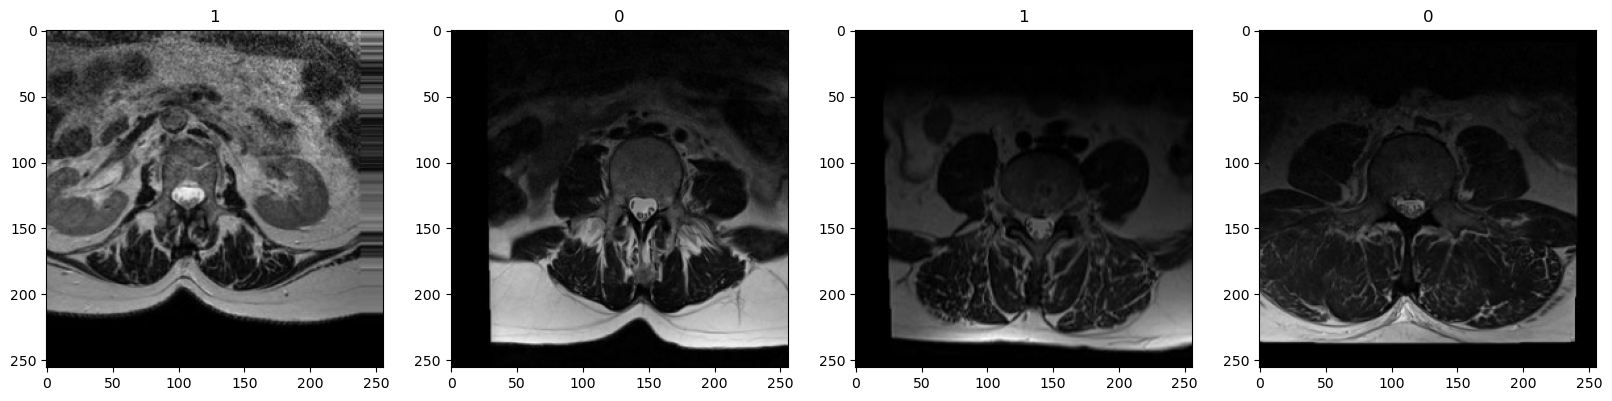

In [10]:
batch = data_iterator.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [11]:
# 2 = Severe
# 1 = Normal_Mild
# 0 = Moderate

# DOUBLE CHECK

## 3. Scale Data

In [12]:
data = data.map(lambda x,y: (x/255, y))

In [ ]:
data.as_numpy_iterator().next()

In [14]:
# In each batch we have a lot of images, or the number we stablish
# Each image is made batch we have 2 objects, the image list and the labels list
# The labels are represented as integers
# The first image in the list goes with the first label in the list, and so on

for element in data.take(1):  # Take the first element
    print(element[1][0])

tf.Tensor(0, shape=(), dtype=int32)


In [15]:
for element in data.take(1):  # Take the first element
    print(element[0][0])

tf.Tensor(
[[[0.12696078 0.12696078 0.12696078]
  [0.12077206 0.12077206 0.12077206]
  [0.11372549 0.11372549 0.11372549]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.10588235 0.10588235 0.10588235]
  [0.10153186 0.10153186 0.10153186]
  [0.09846814 0.09846814 0.09846814]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.0841299  0.0841299  0.0841299 ]
  [0.08284314 0.08284314 0.08284314]
  [0.084375   0.084375   0.084375  ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 ...

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.         0.         0.        ]
  [0.         0.         0

## 4. Split Data

In [16]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)+1

print(len(data), train_size, val_size, test_size)
print(train_size + val_size + test_size)

202 141 40 21
202


In [17]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [18]:
for element in train.take(1):  # Take the first element
    print(element[1])
for element in val.take(1):  # Take the first element
    print(element[1])
for element in test.take(1):  # Take the first element
    print(element[1])

tf.Tensor([1 0 0 2 0 2 1 2 0 0 0 0 0 2 0 1 2 0 2 0 0 1 1 2 1 0 2 0 0 0 1 0], shape=(32,), dtype=int32)
tf.Tensor([1 1 1 2 1 1 0 0 0 1 1 2 0 1 2 1 2 1 2 0 1 0 2 1 2 2 0 1 1 1 2 2], shape=(32,), dtype=int32)
tf.Tensor([2 2 0 1 2 0 1 0 0 1 0 1 2 0 2 1 0 0 1 2 2 0 2 2 0 0 1 0 1 2 2 2], shape=(32,), dtype=int32)


In [19]:
for image, label in train.take(1):
    print(image.shape)  # Should print (batch_size, 256, 256, 3)
    print(label.shape)  # Should match the number of classes


(32, 256, 256, 3)
(32,)


## 5. Build Model

In [22]:
from keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from keras.models import Sequential

In [23]:
model = Sequential()

# Input Layer
model.add(Conv2D(kernel_size=(3, 3), filters=32, activation='relu', input_shape=(256, 256, 3), padding='same'))
model.add(BatchNormalization())  # Stabilize learning
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(2, 2))  # Reduces dimensions to 128x128
model.add(Dropout(0.25))  # Regularization

# Block 2
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(2, 2))  # Reduces dimensions to 64x64
model.add(Dropout(0.25))

# Block 3
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(2, 2))  # Reduces dimensions to 32x32
model.add(Dropout(0.25))

# Block 4
model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(2, 2))  # Reduces dimensions to 16x16
model.add(Dropout(0.25))

# Block 5
model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(2, 2))  # Reduces dimensions to 8x8
model.add(Dropout(0.25))

# Fully Connected Layers
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))  # Regularization
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))  # Assuming 3 classes for classification
    
model.compile(
              loss='sparse_categorical_crossentropy', 
              metrics=['acc'],
              optimizer='adam'
             )

In [24]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 256, 256, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256, 256, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 256, 256, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256, 256, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 21,633,059 (82.52 MB)

 Trainable params: 21,627,555 (82.50 MB)

 Non-trainable params: 5,504 (21.50 KB)

## 6. Train

In [25]:
logdir='logs'

In [26]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [27]:
from tensorflow.keras.callbacks import EarlyStopping

# Define EarlyStopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',  # Metric to monitor, e.g., validation loss
    patience=5,          # Number of epochs with no improvement after which training stops
    restore_best_weights=True  # Restore the weights of the best epoch
)

In [28]:
hist = model.fit(
    train,
    epochs=25,
    validation_data=val,
    callbacks=[tensorboard_callback, early_stopping_callback]
)

Epoch 1/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 1008s 7s/step - acc: 0.3936 - loss: 1.7253 - val_acc: 0.3313 - val_loss: 1.7943
Epoch 2/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 970s 7s/step - acc: 0.4985 - loss: 1.1719 - val_acc: 0.3359 - val_loss: 1.6697
Epoch 3/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 970s 7s/step - acc: 0.6125 - loss: 0.8836 - val_acc: 0.3297 - val_loss: 1.9701
Epoch 4/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 972s 7s/step - acc: 0.6869 - loss: 0.7201 - val_acc: 0.3180 - val_loss: 2.5685
Epoch 5/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 993s 7s/step - acc: 0.7126 - loss: 0.6556 - val_acc: 0.6047 - val_loss: 1.2860
Epoch 6/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 966s 7s/step - acc: 0.6576 - loss: 0.8128 - val_acc: 0.4992 - val_loss: 1.4981
Epoch 7/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 963s 7s/step - acc: 0.6487 - loss: 0.7808 - val_acc: 0.6672 - val_loss: 0.7623
Epoch 8/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 966s 7s/step - acc: 0.7250 - loss: 0.6232 - val_acc: 0.6898 - val_loss: 0.6934
Epoch 9/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 970s 7s

## 7. Plot Performance

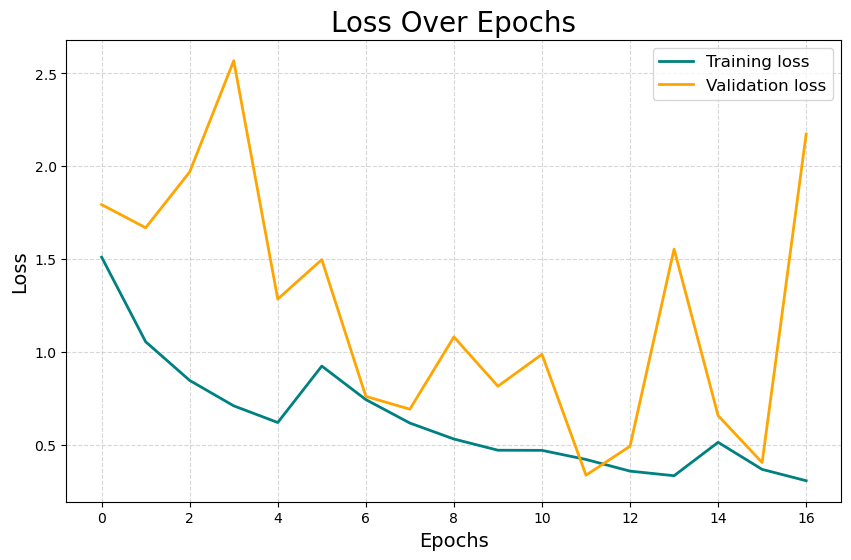

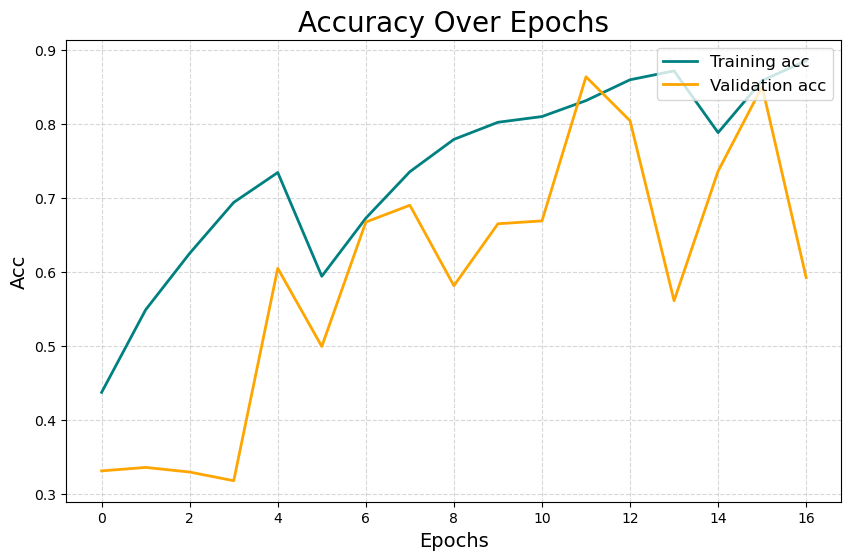

In [29]:
import matplotlib.pyplot as plt

def plot_training_history(hist, metric='loss', val_metric='val_loss', title='Model Training History'):

    fig = plt.figure(figsize=(10, 6))
    
    # Plot training and validation metrics
    plt.plot(hist.history[metric], label=f'Training {metric}', color='teal', linewidth=2)
    plt.plot(hist.history[val_metric], label=f'Validation {metric}', color='orange', linewidth=2)
    
    # Add labels, legend, and title
    plt.title(title, fontsize=20)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel(metric.capitalize(), fontsize=14)
    plt.legend(loc="upper right", fontsize=12)
    plt.grid(visible=True, linestyle='--', alpha=0.5)
    
    # Display the plot
    plt.show()

# Example usage
plot_training_history(hist, metric='loss', val_metric='val_loss', title='Loss Over Epochs')
plot_training_history(hist, metric='acc', val_metric='val_acc', title='Accuracy Over Epochs')


## 8. Evaluate

In [30]:
from sklearn.metrics import classification_report

# Collect all true labels and predictions
y_true_all = []
y_pred_all = []

for batch in test:
    X, y_true = batch
    y_pred = model.predict(X)
    y_pred_classes = tf.argmax(y_pred, axis=1)
    
    y_true_all.extend(y_true.numpy())
    y_pred_all.extend(y_pred_classes.numpy())

# Generate classification report
report = classification_report(y_true_all, y_pred_all, target_names=['Moderate', 'Normal_Mild', 'Severe'])
print(report)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
              precision    recall  f1-score   support

    Moderate       0.80      0.84      0.82       224
 Normal_Mild       0.86      0.71      0.77       231
      Severe       0.82      0.93      0.87       211

    accuracy              

[[189  23  12]
 [ 36 163  32]
 [ 11   4 196]] 



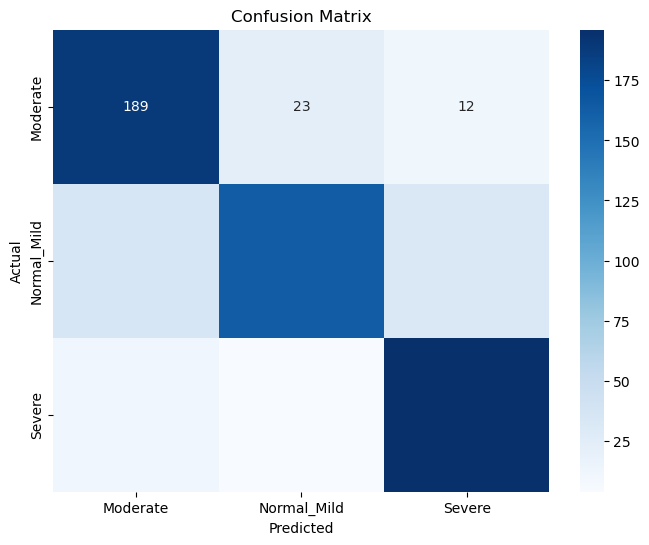

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(y_true_all, y_pred_all)
print(cm, "\n")

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Moderate', 'Normal_Mild', 'Severe'],
            yticklabels=['Moderate', 'Normal_Mild', 'Severe'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


## 10. Save the model

In [32]:
model.save(r'no_rotation_augmented_spinal_canal_classification.h5')

In [93]:
from tensorflow.keras.models import load_model

# Path to the saved model
model_path = r'no_rotation_augmented_spinal_canal_classification.h5'

# Load the model
model = load_model(model_path)

# Confirm the model has been loaded successfully
print("Model loaded successfully.")


Model loaded successfully.


## 11. Test

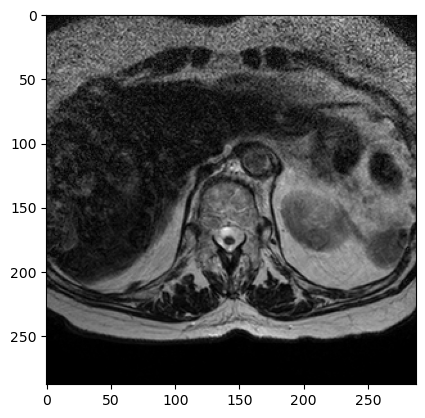

In [164]:
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import numpy as np

img = cv2.imread(r'spinal_canal_stenosis\Normal_Mild\58813022_302608236_53.png')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for displaying
plt.show()

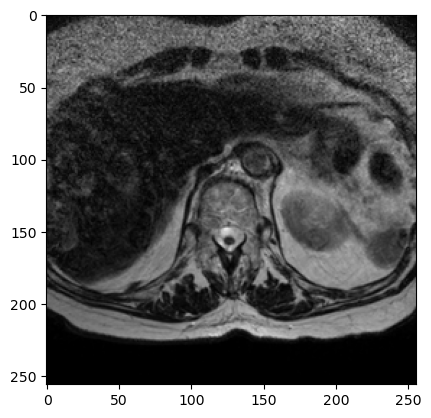

In [165]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [166]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


In [167]:
yhat

array([[0.02316473, 0.9670476 , 0.00978771]], dtype=float32)

In [168]:
# Define the class mapping
class_mapping = {0: 'Moderate', 1: 'Normal_Mild', 2: 'Severe'}

predicted_class = np.argmax(yhat, axis=1)[0]  # Get the index of the highest probability
print(predicted_class)

# Map the predicted class index to the class name
predicted_label = class_mapping[predicted_class]

# Display the result
print(f"Predicted Class Index: {predicted_class}")
print(f"Predicted Label: {predicted_label}")

1
Predicted Class Index: 1
Predicted Label: Normal_Mild
